In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import torch

In [3]:
def plot_colored_quiver(grads, width=0.003, plot_min=False, title=None):
    fig, ax = plt.subplots()

    ax.scatter(grads["sigma"], grads["penalty"], c=grads["loss"], s=4)
    cobj = ax.quiver(grads["sigma"], grads["penalty"], -grads["sigma_g"], -grads["penalty_g"], 
                     grads["loss"], pivot='tail', scale=1, width=width, minshaft=1, headwidth=7,
                    )
    if plot_min:
        min_point = grads.iloc[grads["loss"].argmin()]
        ax.scatter(min_point["sigma"], min_point["penalty"], s=25, c="r")
    ax.set_xlabel("Sigma ($\gamma = 1/2\sigma^2$)")
    ax.set_ylabel("Penalty ($\lambda = e^{-p}$)")
    cbar = fig.colorbar(cobj, ax=ax)
    cbar.ax.set_ylabel('Validation/Test Error', rotation=270, labelpad=18)
    if title is not None:
        ax.set_title(title)
    return fig, ax

def plot_quiver_contour(grads, width=0.003, scale=3, plot_min=False, levels=15, 
                        loss_label="loss", x_label="sigma", x_grad="sigma_g",
                        y_label="penalty", y_grad="penalty_g",
                        x_label_text="Sigma ($\gamma = 1/2\sigma$)",
                        y_label_text="Penalty ($\lambda = e^{-p}$)",
                        colorbar_text = "Validation/Test Error",
                        title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    grads_pvt = grads[[x_label, y_label, loss_label]].pivot(y_label, x_label)
    X = grads_pvt.columns.levels[1].values
    Y = grads_pvt.index.values
    Z = grads_pvt.values
    Xi,Yi = np.meshgrid(X, Y)
    
    cobj = ax.contourf(Xi, Yi, Z, levels=levels)

    ax.quiver(
        grads[x_label], grads[y_label], -grads[x_grad], -grads[y_grad], 
        pivot='tail', scale=scale, width=width, minshaft=1, headwidth=3
    )
    if plot_min:
        min_point = grads.iloc[grads[loss_label].argmin()]
        ax.scatter(min_point[x_label], min_point[y_label], s=25, c="r")
    ax.set_xlabel(x_label_text)
    ax.set_ylabel(y_label_text)
    cbar = fig.colorbar(cobj, ax=ax, use_gridspec=True)
    cbar.ax.set_ylabel(colorbar_text, rotation=270, labelpad=18)
    if title is not None:
        ax.set_title(title)
    return fig, ax

In [4]:
# ./logs/gd_map_svgp_ho-higgs_1605016769776.csv - full train, full test - tiny svgp space.
# ./logs/gd_map_svgp_ho-higgs_1605017409466.csv - larger space (up to 2.5 var)
# ./logs/gd_map_svgp_ho-higgs_1605018242620.csv - up to 5 var

In [5]:
grads.head()

NameError: name 'grads' is not defined

<IPython.core.display.Javascript object>


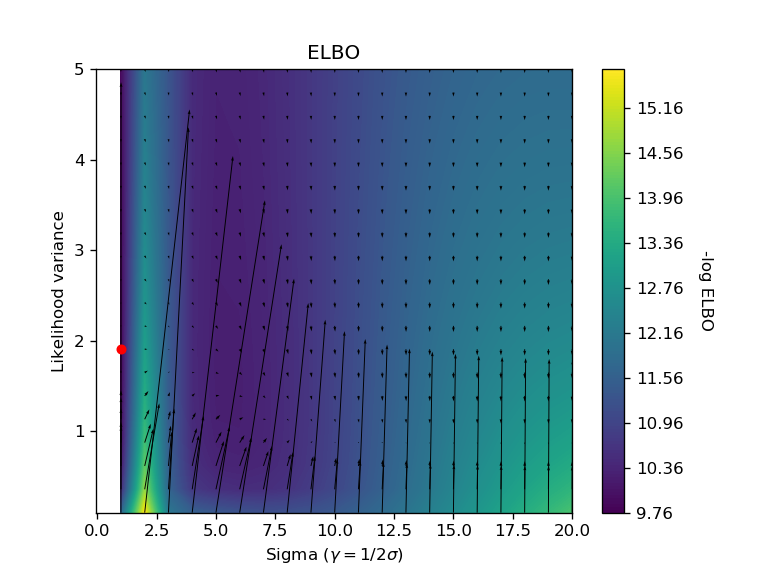

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0995803850>)

In [6]:
fig, ax = plt.subplots()

levels = 160
scale = 1e5

grads = pd.read_csv("./logs/gd_map_svgp_ho-higgs_1605018242620.csv")
grads['elbo'] = np.log(-grads['elbo'])
grads['variance_g'] = grads['variance_g']
grads['sigma_g'] = grads['sigma_g']
# grads = grads[(grads['variance'] < 1) & (grads['variance'] > .05) & (grads['sigma'] < 30)]

plot_quiver_contour(grads, scale=scale, width=0.002, plot_min=True, levels=levels, ax=ax, 
                    title="ELBO", loss_label="elbo",
                    x_label="sigma", x_grad="sigma_g", y_label="variance", y_grad="variance_g",
                    y_label_text="Likelihood variance", colorbar_text="-log ELBO")

## SGPR Experiments


Kernel length-scale parametrization is equal: the kernel lengthscale is $\sigma$ as in the following kernel formula (see code: https://github.com/GPflow/GPflow/blob/develop/gpflow/kernels/stationaries.py)

$$
k(x, x') = e^{-\tfrac{1}{2} \big|\big|\tfrac{x}{\sigma} - \tfrac{x}{\sigma}\big|\big|^2}
$$


Observations on the likelihood variance and its optimization:
 - The gradient for the likelihood variance tends to push it extremely high when starting at low values. For this, using ADAM is necessary since it disregards such high gradient. There is a plateau around 1.
 - Note that the **likelihood variance** plays a **similar role to regularization in KRR**. However it is parametrized differently (e.g. there is no multiplication by *n* in the GP derivations).
 
 

In [196]:
# ./logs/gd_map_sgpr_ho-higgs_1604938558157.csv - 80/20 split for train, full test for test. log-var 1e-3-1e1(10)
# ./logs/gd_map_sgpr_ho-higgs_1604939129309.csv - 80/20 split for train, full test for test. linear var(10)
# ./logs/gd_map_sgpr_ho-higgs_1604939909832.csv - larger space, linear var(20)
# ./logs/gd_map_sgpr_ho-higgs_1604941570926.csv - full train, full test. Good space (linear)
# ./logs/gd_map_sgpr_ho-higgs_1605104441379.csv - full data, good space. kernel variance=3 instead of 1

<IPython.core.display.Javascript object>


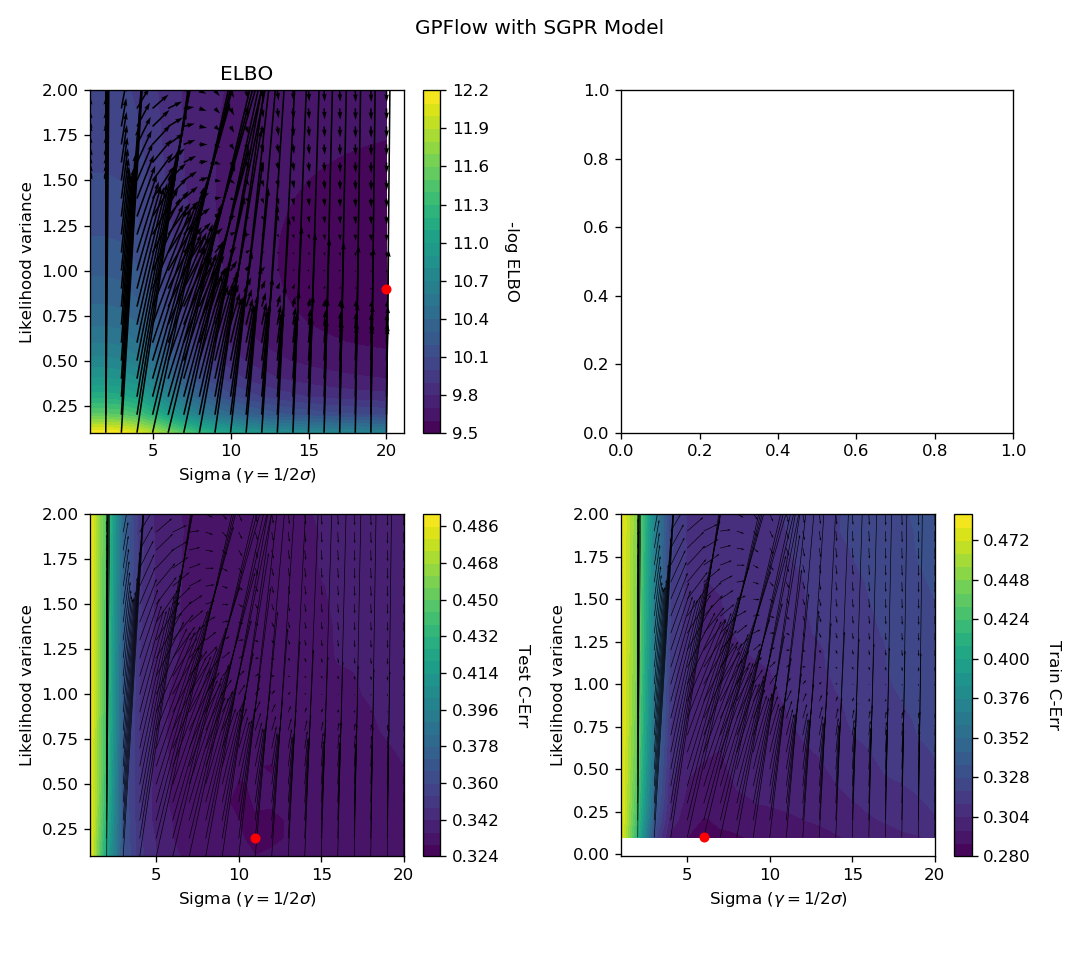

Text(0.5, 0.98, 'GPFlow with SGPR Model')

In [198]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,8))
ax = ax.flatten()
levels = 30
scale = 3e4

grads = pd.read_csv("./logs/gd_map_sgpr_ho-higgs_1605104441379.csv")
grads['elbo'] = np.log(-grads['elbo'])
grads['variance_g'] = grads['variance_g']
grads['sigma_g'] = grads['sigma_g']
#grads = grads[(grads['variance'] < 12) & (grads['variance'] > .25) & (grads['sigma'] < 330)]

#ax.set_yscale('log')
plot_quiver_contour(grads, scale=scale, width=0.005, plot_min=True, levels=levels, ax=ax[0], 
                    title="ELBO", loss_label="elbo",
                    x_label="sigma", x_grad="sigma_g", y_label="variance", y_grad="variance_g",
                    y_label_text="Likelihood variance", colorbar_text="-log ELBO")
plot_quiver_contour(grads, scale=scale, width=0.002, plot_min=True, levels=levels, ax=ax[2], 
                    title="", loss_label="test_c-error",
                    x_label="sigma", x_grad="sigma_g", y_label="variance", y_grad="variance_g",
                    y_label_text="Likelihood variance", colorbar_text="Test C-Err")
plot_quiver_contour(grads, scale=scale, width=0.002, plot_min=True, levels=levels, ax=ax[3], 
                    title="", loss_label="train_c-error",
                    x_label="sigma", x_grad="sigma_g", y_label="variance", y_grad="variance_g",
                    y_label_text="Likelihood variance", colorbar_text="Train C-Err")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("GPFlow with SGPR Model")

## Falkon Experiments

Large plateau with low sigma and high penalty which is caused by the predictions of falkon being uninformative (e.g. all zeros)? This means that it is **necessary** to start with $\sigma > 1$, otherwise optimization (even ADAM) will remain stuck on the plateau.


Comparing to SGPR: the region of good sigmas seems to be somewhat similar, which is reassuring.

In [288]:
# 1604329450795 : 80/20 split of the training data. 40 stops per dimension. Val-gradient. PenalizedMSE
# 1604333319344 : all data for train and all for test. 40 stops per dimension. Val-gradient. PenalizedMSE
# 1604334212493 : all data. 80 stops per dimension, larger range. Val-gradient. PenalizedMSE
# 1604397535342 : all data. 60 stops, 0.1--20. Hyper-gradient. PenalizedMSE
# 1604399343222 : all data. 60 stops, 0.1--20. Hyper-gradient. MSE
# 1604400378218 : split data. 60 stops, 0.1--20. Hyper-gradient. MSE
# 1604413851305 : all data. 60 stops, 0.1--20. Hyper-gradient. MSE + errors
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")

<IPython.core.display.Javascript object>


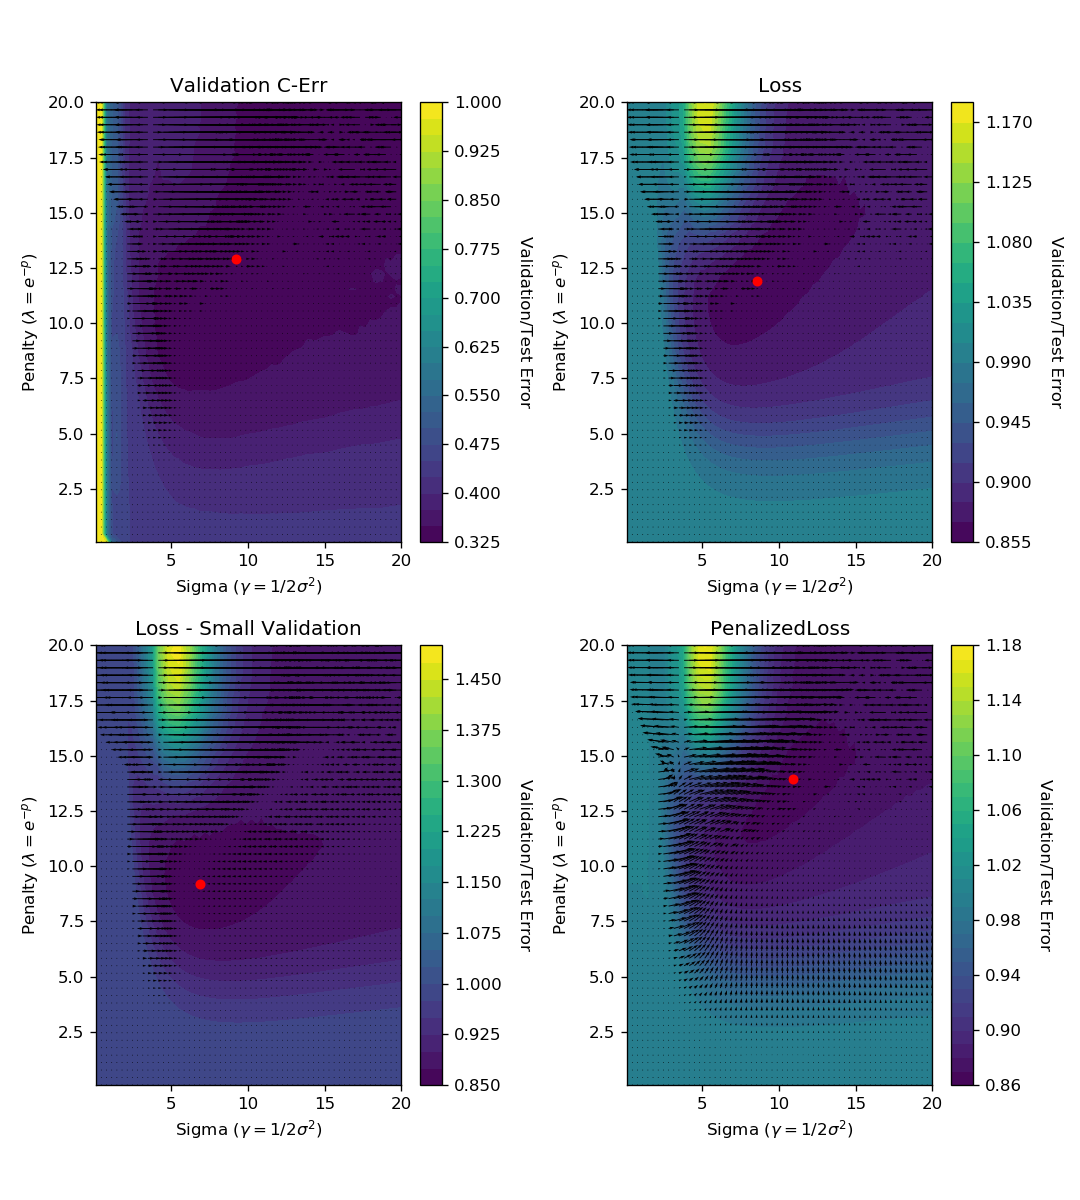

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,10))
ax = ax.flatten()
levels = 30
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="test_c-error", 
                    title="Validation C-Err", ax=ax[0])
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="Loss", ax=ax[1])

grads = pd.read_csv("./logs/gd_map_ho-higgs_1604397535342.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="PenalizedLoss", ax=ax[3])
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604400378218.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="Loss - Small Validation", ax=ax[2])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Falkon")

In [9]:
def plot_trajectory(ax, traj, cmap, norm):
    ax.plot(traj['sigma'], traj['penalty'], linewidth=1.5, c='k')
    ax.scatter(traj['sigma'], traj['penalty'], c=traj['loss'], s=25, marker='x', cmap=cmap, norm=norm)
    
def plot_traj_contour(grads, traj, plot_min=False, levels=15, title=None, loss_var="loss", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    cmap = plt.cm.viridis
    norm = clr.Normalize(vmin=grads[loss_var].min(), vmax=grads[loss_var].max())
    
    grads_pvt = grads[["sigma", "penalty", loss_var]].pivot("penalty", "sigma")
    X = grads_pvt.columns.levels[1].values
    Y = grads_pvt.index.values
    Z = grads_pvt.values
    Xi,Yi = np.meshgrid(X, Y)
    cobj = ax.contourf(Xi, Yi, Z, levels=levels, cmap=cmap, norm=norm)
    
    if plot_min:
        min_point = grads.iloc[grads[loss_var].argmin()]
        ax.scatter(min_point["sigma"], min_point["penalty"], s=25, c="r")

    cbar = fig.colorbar(cobj, ax=ax)
    cbar.ax.set_ylabel('Validation/Test Error', rotation=270, labelpad=18)

    if isinstance(traj, list):
        for t in traj:
            plot_trajectory(ax, t, cmap, norm)
    else:
        plot_trajectory(ax, traj, cmap, norm)
    ax.set_xlabel("Sigma ($\gamma = 1/2\sigma^2$)")
    ax.set_ylabel("Penalty ($\lambda = e^{-p}$)")
    
    if title is not None:
        ax.set_title(title)
    return fig, ax

In [272]:
# 1604335141944 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336090086 - lr 0.5 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336282136 - lr 0.1 hess_steps 20 flk_steps 20 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336627714 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float64 PenalizedMSE
# 1604399771937 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE
# 1604399841811 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 250 seed 129 float32 MSE
# 1604399898527 - lr 0.2 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE
# 1604411462823 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=1
# 1604411605732 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=3
# 1604411929862 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=5, penalty=20
# 1604412050570 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=5, penalty=15

trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604399841811.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411929862.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411605732.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412050570.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412168791.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412718471.csv"),
]

<IPython.core.display.Javascript object>


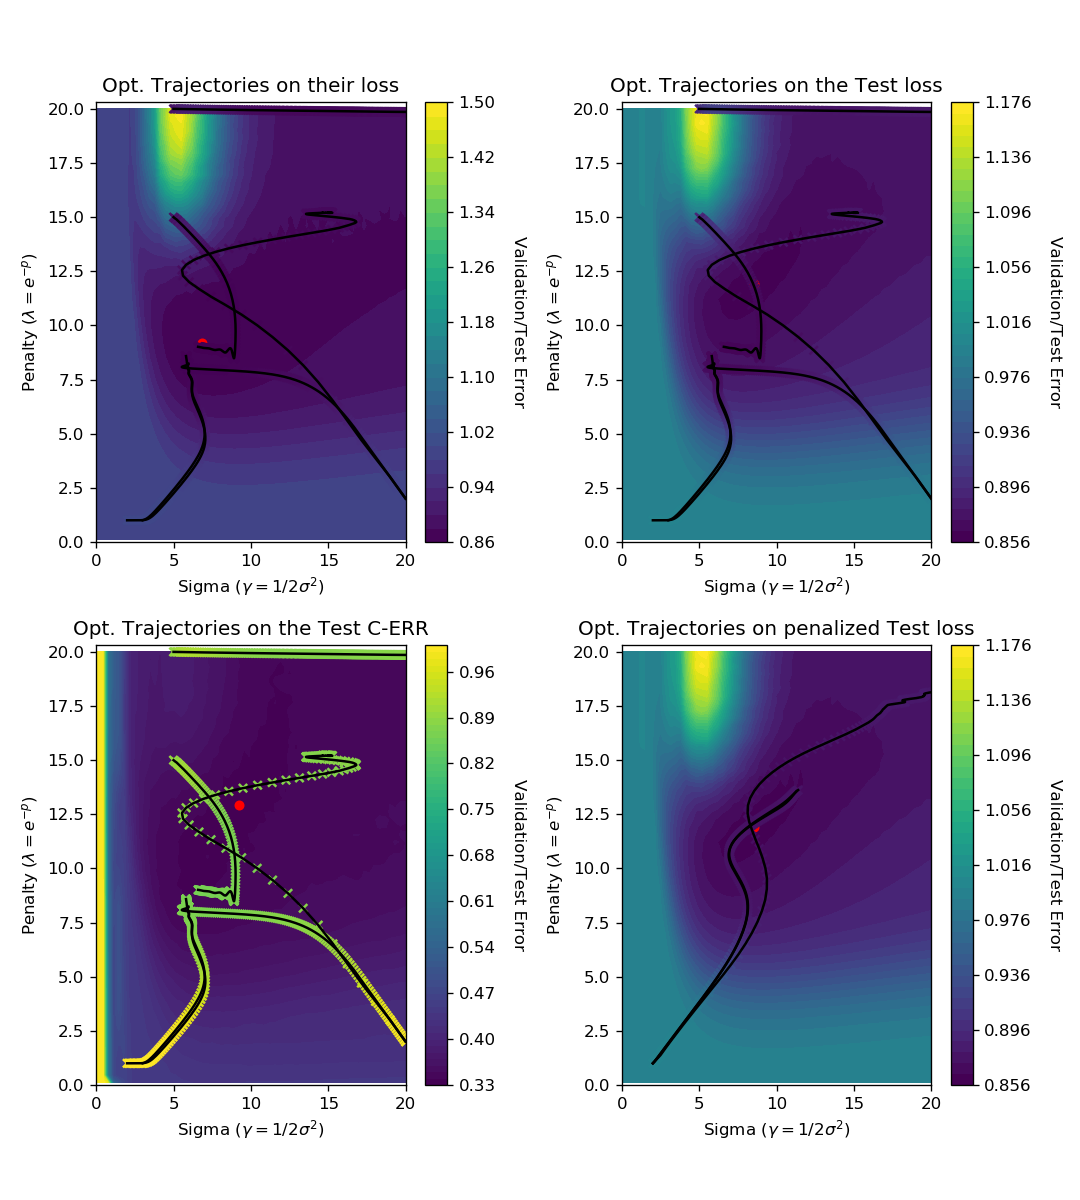

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,10))
ax = ax.flatten()
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604400378218.csv")
trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604399841811.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411929862.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411605732.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412050570.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412168791.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412718471.csv"),
]
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[0], 
                  title="Opt. Trajectories on their loss")
ax[0].set_xlim([0, 20])
ax[0].set_ylim([0, 20.3])

grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[1], 
                  title="Opt. Trajectories on the Test loss")
ax[1].set_xlim([0, 20])
ax[1].set_ylim([0, 20.3])

plot_traj_contour(grads, trajs, plot_min=True, levels=80, loss_var="test_c-error", ax=ax[2], 
                  title="Opt. Trajectories on the Test C-ERR")
ax[2].set_xlim([0, 20])
ax[2].set_ylim([0, 20.3])


trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604335141944.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604336090086.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604336282136.csv"),
]
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[3], 
                  title="Opt. Trajectories on penalized Test loss")
ax[3].set_xlim([0, 20])
ax[3].set_ylim([0, 20.3])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<IPython.core.display.Javascript object>


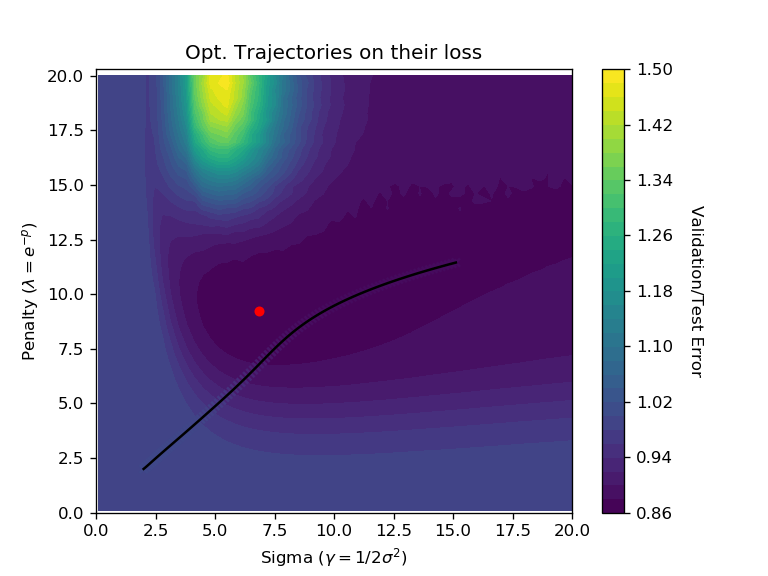

(0, 20.3)

In [11]:
fig, ax = plt.subplots()
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604400378218.csv")
trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1607960088133.csv"),
]
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax, 
                  title="Opt. Trajectories on their loss")
ax.set_xlim([0, 20])
ax.set_ylim([0, 20.3])


## Train/Test

In [1]:
from benchmark_utils import Dataset
from datasets import get_load_fn, equal_split
from error_metrics import get_err_fns
import falkon
from falkon import Falkon, InCoreFalkon
# from falkon.kernels.diff_rbf_kernel import DiffGaussianKernel
from falkon.kernels import GaussianKernel
from falkon.center_selection import FixedSelector

In [4]:
dset = Dataset.HOHIGGS
Xtr, Ytr, Xts, Yts, metadata = get_load_fn(dset)(np.float32, as_torch=True)
cs = FixedSelector(torch.from_numpy(metadata['centers']).cuda())

Loaded HIGGSHO dataset in <class 'numpy.float32'> precision.
Split the data into 10000 training, 20000 validation points of dimension 28.
Data-preprocessing completed.


In [5]:
def c_err(y_true, y_pred):
    if not isinstance(y_true, np.ndarray):
        y_true: np.ndarray = y_true.numpy()
    if not isinstance(y_pred, np.ndarray):
        y_pred: np.ndarray = y_pred.numpy()
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1) * 2 - 1
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1) * 2 - 1
    return np.mean(np.sign(y_pred.ravel()) != np.sign(y_true.ravel())), "c-err"

In [6]:
sigma = torch.tensor([9.757151556976527])
penalty = 3.162277660168379e-05

kernel = GaussianKernel(sigma)
err_fns = get_err_fns(dset)
flk = InCoreFalkon(
    kernel=kernel,
    penalty=penalty,
    M=metadata['centers'].shape[0],
    center_selection=cs,
    maxiter=20,
    seed=1110,
    options=falkon.FalkonOptions())
flk.fit(Xtr.cuda(), Ytr.cuda())#, Xts.cuda(), Yts.cuda())
test_pred = flk.predict(Xts.cuda())
err, err_name = c_err(Yts, test_pred.cpu())
print("Test %s: %.2f%%" % (err_name, err*100))

Test c-err: 34.02%


In [57]:
Ytr[0]

tensor([-1.])

In [60]:
flk.alpha_[:10]

tensor([[ 0.0487],
        [ 0.2392],
        [ 0.2174],
        [ 0.6767],
        [-0.3917],
        [-0.2514],
        [-0.8750],
        [-0.1528],
        [-0.6408],
        [-0.0088]], device='cuda:0')